# Channel Estimation

In [1]:
using DSP
using FFTW

In [2]:
# Some Math tools
# Inverse Fourier Transform function
Fᴵ = ifft 

# Convolution infix operation
function ⊗(a, b) 
    return conv(a,b)
end


⊗ (generic function with 1 method)

In [3]:
include("rxsignal_withchannelandfreqoff.jl");

In [4]:
# RX Received Signal 3
Ŝᵣₓ³ = rxs3;

In [5]:
include("pss2.jl");

In [6]:
# pss_2 signals from the Matlab File
PSS₂ᵀ = transpose.(pss_2); # Hessian Transpose ?

In [7]:
# some math notations

# PSS₂ᵀ just to make it nice
# Transpose postfix operation
struct Transposer end
const ᵀ = Transposer() #typed \^T<TAB>
Base.:(*)(x, ::Transposer) = transpose(x)

# Sum
∑ = sum

sum (generic function with 13 methods)

In [8]:
using LinearAlgebra

In [9]:
Ŝₚₛₛ₂ = Fᴵ(PSS₂ᵀ); # S Slanted (fourier transform) in time domain
Ŝₚₛₛ₂ ./= norm(Ŝₚₛₛ₂); 
Ŝₚₛₛ₂ = vcat(Ŝₚₛₛ₂[(end-143):end], Ŝₚₛₛ₂); size( Ŝₚₛₛ₂ )  # end is 2048 in this case, concat math 

(2192,)

In [10]:
S̅ₚₛₛ² = reverse(Ŝₚₛₛ₂); # reverse
S̅ₚₛₛ²ᴴ = conj(S̅ₚₛₛ²); # conjugate 
argmax = findmax

findmax (generic function with 8 methods)

In [11]:
m̂₂ = 10 * log10.(abs.( Ŝᵣₓ³ ⊗ S̅ₚₛₛ²ᴴ )); size( m̂₂ )

(618638, 1)

In [12]:
# Find maximum value and its index
Ĉᵩ², 𝑁̂𝑓² = argmax(m̂₂) #; m2_chan[NF2_chan] or direct m2_chan[(6628)...] 

(50.649042476081405, CartesianIndex(6628, 1))

In [13]:
Nf = getindex(𝑁̂𝑓², 1)

6628

In [38]:
########################################################
# Frequency Offset Estimator Function
########################################################
function freq_offset_est(Ŝᵣₓ, Ŝₚₛₛ, Nf)

    # Frequency offset estimator

    Δ𝑓 = 10.0

    𝑓ₛ = 61.44e6
    f_min = -7500.
    f_max = 7500.

    m = f_min:Δ𝑓:f_max; @show m
    Y = zeros(ComplexF64, length(m))
    L = length(Ŝₚₛₛ); @show L
    t = 0:(1/𝑓ₛ):((L-1)/𝑓ₛ); @show t

    signal_part = Ŝᵣₓ[Nf:(Nf + L -1)]; @show size( signal_part )
    transConj = conj(Ŝₚₛₛ) .* transpose(signal_part); size( transConj )

    for j = 1:length(m)
        exp_comp = exp.(-2*pi*1.0im*m[j].*t)
        signal_offset = ∑(exp_comp .* transConj)
        value = abs.(signal_offset)
        Y[j] += value
    end

    return Y
end

freq_offset_est (generic function with 1 method)

In [40]:
# Grab the function Profs Frequency Offset with his values
Y = freq_offset_est(Ŝᵣₓ³, Ŝₚₛₛ₂, getindex(𝑁̂𝑓², 1) - length(Ŝₚₛₛ₂) + 1);

m = -7500.0:10.0:7500.0
L = 2192
t = 0.0:1.6276041666666667e-8:3.566080729166667e-5
size(signal_part) = (2192,)


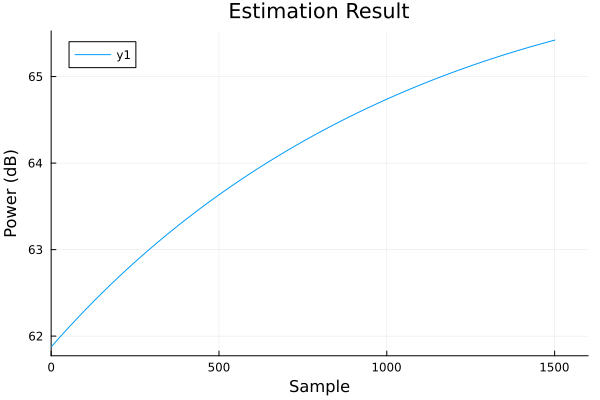

In [42]:
using Plots
Y_1 = 10 * log10.(abs.(Y))
# cfo_estim_plot = 
plot(Y_1, xlabel="Sample", ylabel="Power (dB)", title="Estimation Result"
    , xlim=(0, 1600)
    # , ylim=(1e10, 1.40e10)
)
# savefig(cfo_estim_plot,"images/cfo_estim_plot.png");

<img src="images/cfo_estim_plot.png" weight='' height='' > </img>

In [100]:
# scatter(real(Y_1), imag(Y_1), label="roots"
    # ,xlims=(-1.2,1.2)
    # , ylims=(-1.2,1.2)
    # , aspect_ratio=1
    # , xlabel="Real part", ylabel="Imaginary part"
# )

In [101]:
# (A_fo, fo) = findmax(Y)
# println("m ", length(m), ", A_fo ", A_fo, ", fo ", fo)